# Make All Figures for Main Manuscript

Kendra Wyant  
January 27, 2025

In [ ]:

suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(source("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true"))
suppressPackageStartupMessages(library(tidyposterior))
library(kableExtra, exclude = "group_rows")
library(patchwork)

theme_set(theme_classic())

path_models_lag <- format_path(str_c("studydata/risk/models/lag"))
path_shared <- format_path("studydata/risk/data_processed/shared")
path_processed <- format_path("studydata/risk/data_processed/lag")


Data for figures

In [ ]:
test_metrics_all_pp_perf <- read_csv(here::here(path_models_lag,
                                                "pp_perf_tibble.csv"),
                                     show_col_types = FALSE)

pp_dem <- read_csv(here::here(path_models_lag, "pp_dem_all.csv"),
                            show_col_types = FALSE)

global_all <- read_rds(here::here(path_models_lag, "shap_global_all.rds")) |> 
   filter(str_detect(variable_grp, "EMA")) |> 
   mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"),
          variable_grp = reorder(variable_grp, mean_value, sum),
          model = factor(model, levels = c("336 lag", "168 lag", "72 lag", "24 lag", "0 lag"),
                         labels = c("2 weeks", "1 week", "3 days", "1 day", "No lag" ))) |> 
  filter(model %in% c("2 weeks", "No lag"))

shap_levels <- global_all |>
  mutate(variable_grp = reorder(variable_grp, mean_value, sum)) |>
  pull(variable_grp) |>
  levels()


## Figure 1: Prediction Methods

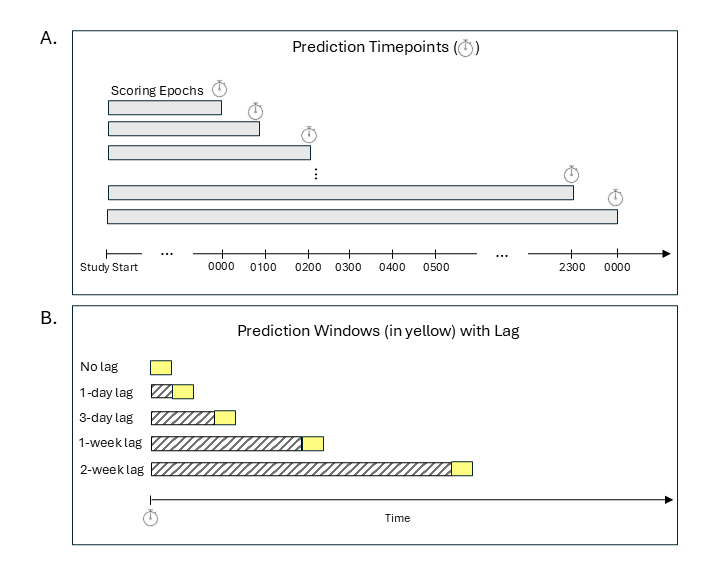

In [ ]:

knitr::include_graphics(path = here::here("figures/methods.png"), error = FALSE)


## Figure 2: Posterior probability for auROC by model and demographic group differences

In [ ]:
fig_2a <- test_metrics_all_pp_perf |>
  mutate(model_numeric = case_when(model == "336 lag" ~ as.numeric(336),
                                   model == "168 lag" ~ as.numeric(168),
                                   model == "72 lag" ~ as.numeric(72),
                                   model == "24 lag" ~ as.numeric(24),
                                   model == "0 lag" ~ as.numeric(0))) |> 
  ggplot() + 
  geom_point(aes(x = model_numeric, y = pp_median), color = "black") +
  geom_line(aes(x = model_numeric, y = pp_median)) +
  geom_segment(mapping = aes(x = model_numeric, y = pp_lower, yend = pp_upper)) +
  scale_y_continuous("auROC", limits = c(.50, 1.0)) +
  scale_x_continuous("Model Lag", breaks = c(0, 24, 72, 168, 336), 
                     labels = c("No lag", "1 day", "3 days", "1 week",
                                "2 weeks")) +
  theme_classic() +
  theme(legend.position = "none",
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1)) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black")


In [ ]:
pp_dem <- pp_dem |>
  mutate(contrast = factor(model, levels = c("not white", 
                                             "non-hispanic white",
                                             "female",
                                             "male",
                                             "below poverty",
                                             "above poverty"),
                           labels = c("Not White vs. Non-Hispanic White",
                                      "Not White vs. Non-Hispanic White",
                                      "Female vs. Male",
                                      "Female vs. Male",
                                      "Below Poverty vs. Above Poverty",
                                      "Below Poverty vs. Above Poverty")),
         group = factor(model, levels = c("non-hispanic white",
                                          "not white", 
                                          "female",
                                          "male",
                                          "below poverty",
                                          "above poverty"),
                        labels = c("advantaged group (non-Hispanic White, male, above poverty)", 
                                   "disadvantaged group (not White, female, below poverty)",
                                   "disadvantaged group (not White, female, below poverty)",
                                   "advantaged group (non-Hispanic White, male, above poverty)",
                                   "disadvantaged group (not White, female, below poverty)",
                                   "advantaged group (non-Hispanic White, male, above poverty)"))) 

pp_dem_a <- pp_dem |> 
  filter(contrast == "Not White vs. Non-Hispanic White" & lag %in% c(0, 336)) |> 
  mutate(lag = factor(lag),
         contrast = "Race/Ethnicity") |> 
  ggplot() + 
  geom_point(aes(x = lag, y = pp_median, color = group)) +
  geom_segment(mapping = aes(x = lag, y = pp_lower, yend = pp_upper, color = group)) +
  facet_wrap(~ contrast) +
  scale_y_continuous("auROC", limits = c(.35, 1.0)) +
  scale_x_discrete(NULL, labels = c("No lag", "2 weeks")) +
  theme_classic() +
  theme(panel.border = element_rect(colour = "black", fill = NA, linewidth = 1)) +
  scale_color_manual(values = c("#240e31", "#cb6bce")) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +
  labs(color = NULL)

pp_dem_b <- pp_dem |> 
  filter(contrast == "Female vs. Male" & lag %in% c(0, 336)) |> 
  mutate(lag = factor(lag),
         contrast = "Sex at birth") |> 
  ggplot() + 
  geom_point(aes(x = lag, y = pp_median, color = group)) +
  geom_segment(mapping = aes(x = lag, y = pp_lower, yend = pp_upper, color = group)) +
  facet_wrap(~ contrast) +
  scale_y_continuous(NULL, limits = c(.35, 1.0)) +
  scale_x_discrete("Model Lag", labels = c("No lag", "2 weeks")) +
  theme_classic() +
  theme(panel.border = element_rect(colour = "black", fill = NA, linewidth = 1)) +
  scale_color_manual(values = c("#240e31", "#cb6bce")) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +
  labs(color = NULL)

pp_dem_c <- pp_dem |> 
  filter(contrast == "Below Poverty vs. Above Poverty" & lag %in% c(0, 336)) |> 
  mutate(lag = factor(lag),
         contrast = "Income") |> 
  ggplot() + 
  geom_point(aes(x = lag, y = pp_median, color = group)) +
  geom_segment(mapping = aes(x = lag, y = pp_lower, yend = pp_upper, color = group)) +
  facet_wrap(~ contrast) +
  scale_y_continuous(NULL, limits = c(.35, 1.0)) +
  scale_x_discrete(NULL, labels = c("No lag", "2 weeks")) +
  theme_classic() +
  theme(panel.border = element_rect(colour = "black", fill = NA, linewidth = 1)) +
  scale_color_manual(values = c("#240e31", "#cb6bce")) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +
  labs(color = NULL)

fig_2b <- pp_dem_a + pp_dem_b + pp_dem_c + plot_layout(guides = "collect") &
  theme(legend.position = "bottom", legend.direction = "vertical") 

fig_2 <- (fig_2a / fig_2b) &
  plot_annotation(tag_levels = "A")


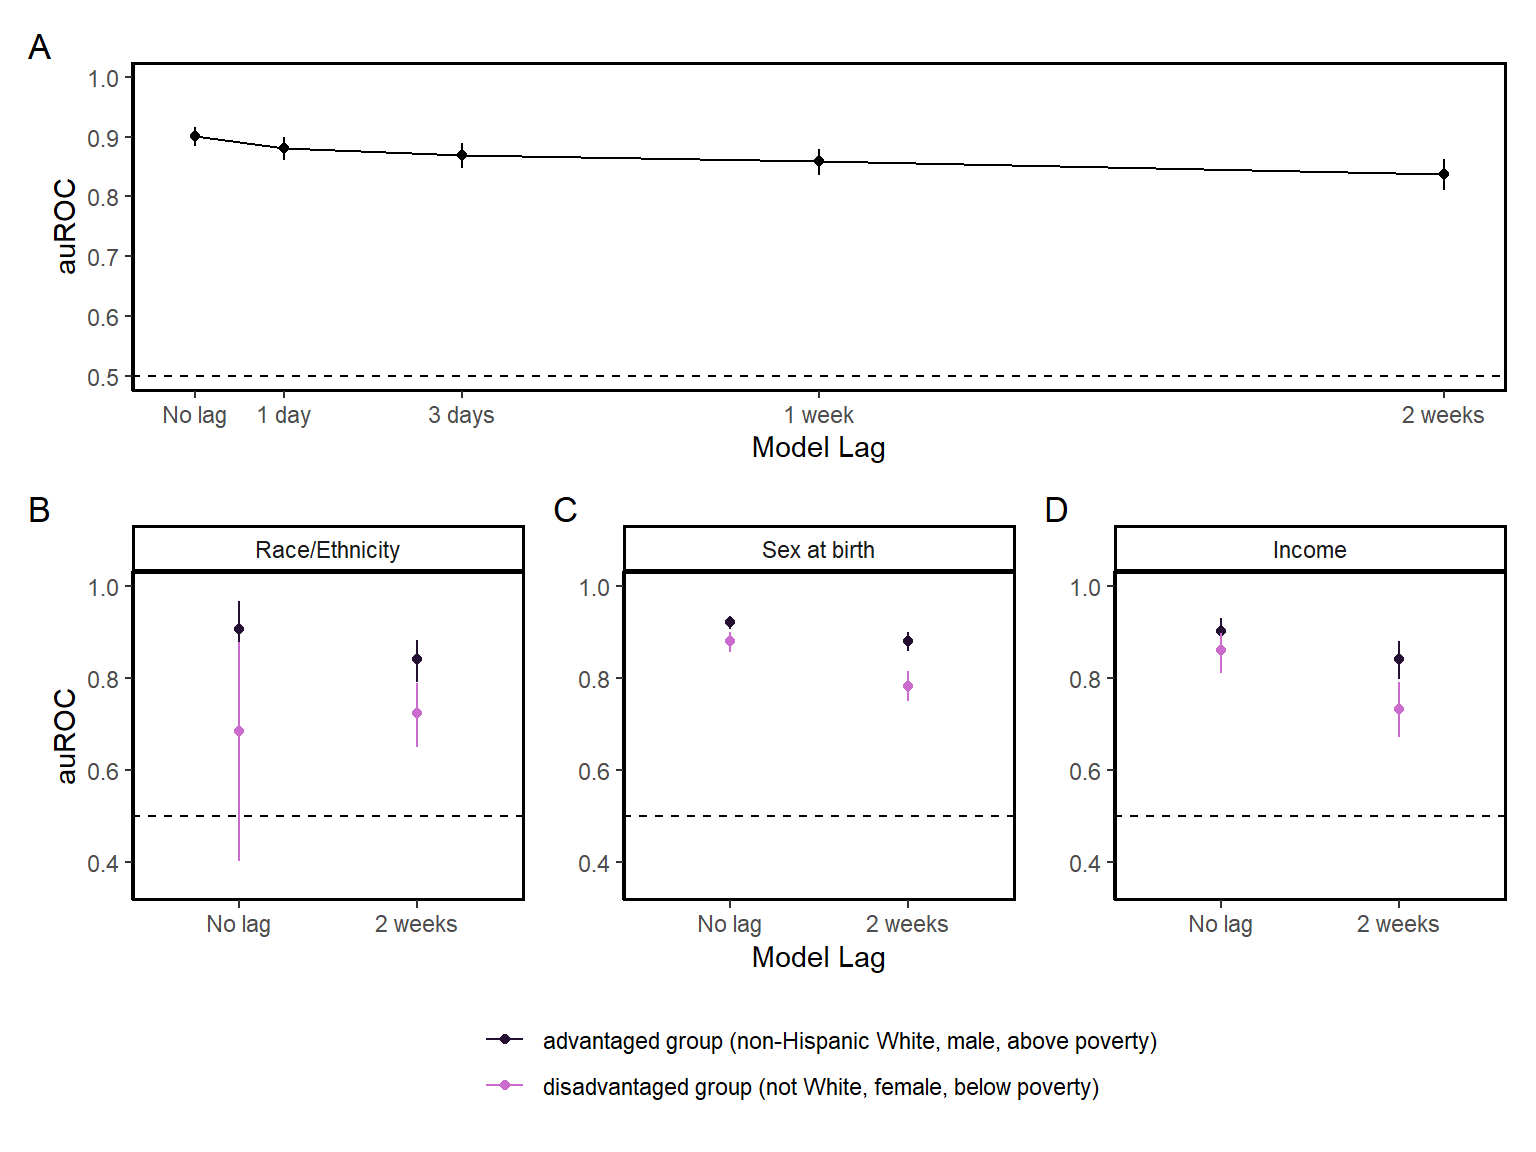

In [ ]:

fig_2 


## Figure 3: Global and Local Shapley Plots

In [ ]:
global_panel <- global_all |>
  ggplot() +
  geom_bar(aes(x = variable_grp, y = mean_value, fill = model), 
           stat = "identity", position = "dodge") +
  labs(y = "Mean(|Shapley Value|)",
       x = NULL,
       fill = NULL) +
  scale_fill_manual(values = c("#458892", "#751c6d")) +
  theme(axis.text=element_text(size=9.5),
        legend.key.size = unit(0.25, "cm"),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
        legend.position = "right") +
  coord_flip()


In [ ]:
shap_feat_0 <- read_rds(here::here(path_models_lag, "outer_shapsgrp_1day_0_v3_nested_main_downsized.rds")) |> 
  filter(str_detect(variable_grp, "EMA")) |> 
  mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"),
         variable_grp = factor(variable_grp, levels = shap_levels))

shap_feat_336 <- read_rds(here::here(path_models_lag, "outer_shapsgrp_1day_336_v3_nested_main_downsized.rds")) |> 
  filter(str_detect(variable_grp, "EMA")) |> 
  mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"),
         variable_grp = factor(variable_grp, levels = shap_levels))

panel_shap_local_0 <- shap_feat_0 |>
  ggplot(mapping = aes(x = variable_grp, y = value)) +
  ggforce::geom_sina(method = "counts", maxwidth = .7, alpha = .7,  color = "#52144d") +
  geom_hline(yintercept = 0) +
  scale_y_continuous(limits = c(-2, 6), breaks = seq(-2, 6)) +
  ylab("Shapley Value (No Lag)") +
  xlab(NULL) +
  labs(color = NULL) +
  theme(legend.position = "right",
        legend.key.size = unit(0.25, "cm"),
        axis.text=element_text(size=9.5),
        axis.text.y = element_blank(),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))+
  coord_flip()

panel_shap_local_336 <- shap_feat_336 |>
  ggplot(mapping = aes(x = variable_grp, y = value)) +
  ggforce::geom_sina(method = "counts", maxwidth = .7, alpha = .7, color = "#295157") +
  geom_hline(yintercept = 0) +
  scale_y_continuous(limits = c(-2, 5.5), breaks = seq(-2, 5)) +
  ylab("Shapley Value (2-week Lag)") +
  xlab(NULL) +
  labs(color = NULL) +
  theme(legend.position = "right",
        legend.key.size = unit(0.25, "cm"),
        axis.text=element_text(size=9.5),
        axis.text.y = element_blank(),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))+
  coord_flip()


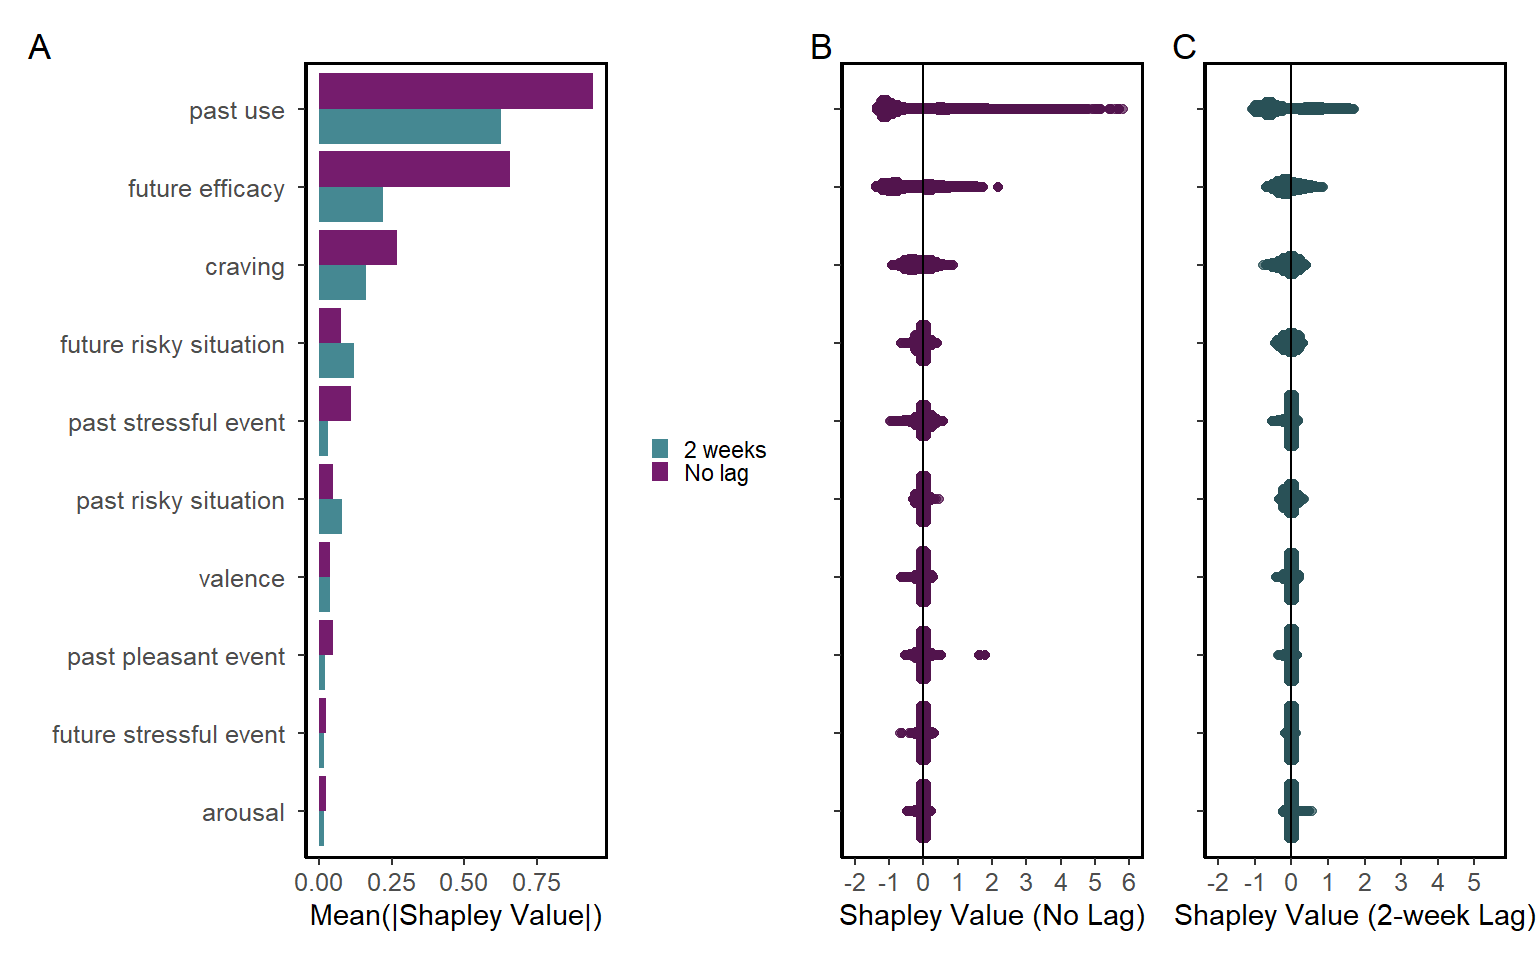

In [ ]:

global_panel + panel_shap_local_0 + panel_shap_local_336  + 
  plot_annotation(tag_levels = "A") 
